In [30]:
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from pybaselines.whittaker import arpls

In [31]:
def load_and_preprocess_spectrum(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None)
    df = df[0].str.split(";", expand=True)
    df = df.drop(columns=[2])
    df = df.astype(float)
    df = df.rename(columns={0: 'wave_number', 1: 'intensity'})

    channel_1 = df['intensity'].values

    # Apply ARPLS baseline correction from the whittaker module
    channel_2 = arpls(channel_1)[0]  # Extract only the corrected intensity array

    # Apply other pre-processing techniques if needed
    channel_3 = savgol_filter(df['intensity'].values, window_length=11, polyorder=3)
    channel_4 = df['intensity'].values / np.linalg.norm(df['intensity'].values)

    return np.stack([channel_1, channel_2, channel_3, channel_4], axis=1)

def load_data(directory):
    X = []
    y = []
    class_labels = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(directory)))}

    for class_name, class_idx in class_labels.items():
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                multi_channel_input = load_and_preprocess_spectrum(file_path)
                X.append(multi_channel_input)
                y.append(class_idx)

    X = np.array(X)
    y = np.array(y)
    return X, y, class_labels

In [32]:
# Load and preprocess all data
X, y, class_labels = load_data('dataset')

print("Data shape:", X.shape)  # Should be (m_samples, n_features, o_channels)
print("Labels:", y)
print("Class labels mapping:", class_labels)

Data shape: (537, 2005, 4)
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

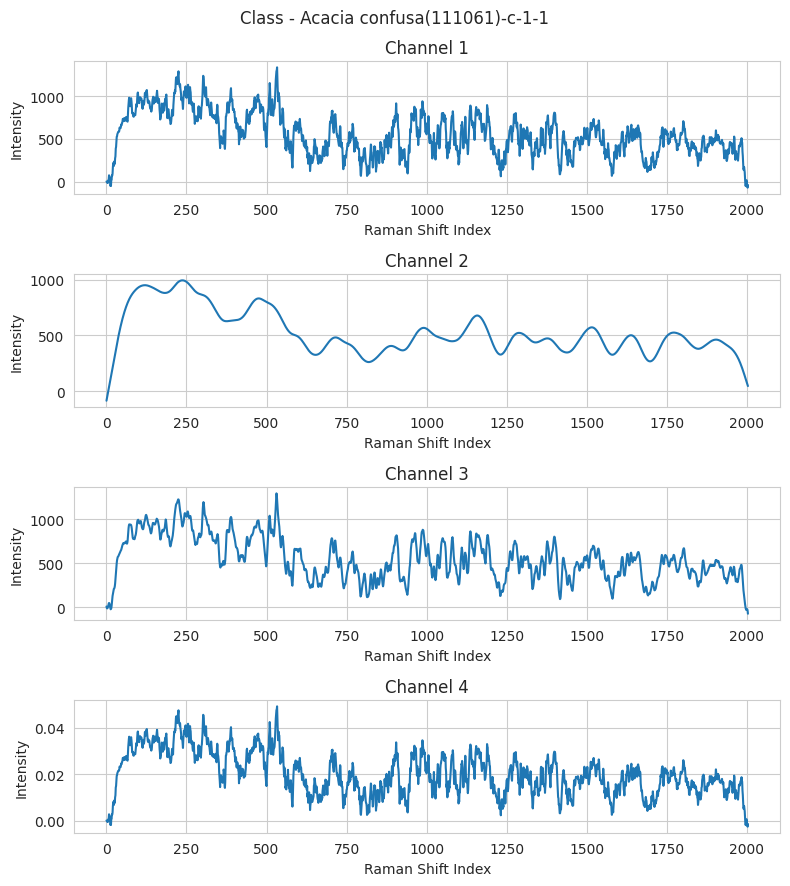

In [33]:
# see different data pruned by different channel(example from first data of first class)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 9))
plt.suptitle('Class - Acacia confusa(111061)-c-1-1')
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(X[0, :, i])
    plt.title(f'Channel {i+1}')
    plt.xlabel('Raman Shift Index')
    plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

In [39]:
# Concatenate all channels into a single feature vector
# Best cross-validation accuracy: 0.9795
# Test Set Accuracy: 0.9907
# X_reshaped = X.reshape(X.shape[0], -1)

# Only choose Channel 4 to train the model
# Best cross-validation accuracy: 0.9870
# Test Set Accuracy: 1.0
# X_reshaped = X[:, :, 3]

# Only choose Channel 3 to train the model
# Best cross-validation accuracy: 0.9609
# Test Set Accuracy: 0.9814
# X_reshaped = X[:, :, 2]

# Only choose Channel 2 to train the model(worst)
# Best cross-validation accuracy: 0.8994
# Test Set Accuracy: 0.9166
X_reshaped = X[:, :, 1]

# Only choose Channel 1 to train the model
# Best cross-validation accuracy: 0.9609
# Test Set Accuracy: 0.9814
# X_reshaped = X[:, :, 0]

# Apply scaling
minmax_scaler = MinMaxScaler()
X_minmax_scaled = minmax_scaler.fit_transform(X_reshaped)

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_minmax_scaled, y_encoded, test_size=0.2, random_state=42)


In [40]:
# Show label's name
class_labels 


{'class_Acacia confusa': 0,
 'class_Chamaecyparis formosensis Matsum': 1,
 'class_Cinnamomum kanehirae': 2,
 'class_Cryotomeria japonica': 3,
 'class_Cunninghamia lanceolata': 4,
 'class_Eucalyptus deglupta': 5,
 'class_Fagus': 6,
 'class_Fokienia hodginsii': 7,
 'class_Intsia bijuga': 8,
 'class_Swietenia macrophylla': 9}

Best parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best cross-validation accuracy: 0.8994634821737625
Test Set Accuracy: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       0.95      1.00      0.97        19
           2       0.78      0.88      0.82         8
           3       1.00      0.78      0.88         9
           4       0.78      0.88      0.82         8
           5       1.00      1.00      1.00         6
           6       0.87      0.87      0.87        15
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00        13
           9       1.00      0.77      0.87        13

    accuracy                           0.92       108
   macro avg       0.92      0.92      0.92       108
weighted avg       0.92      0.92      0.92       108



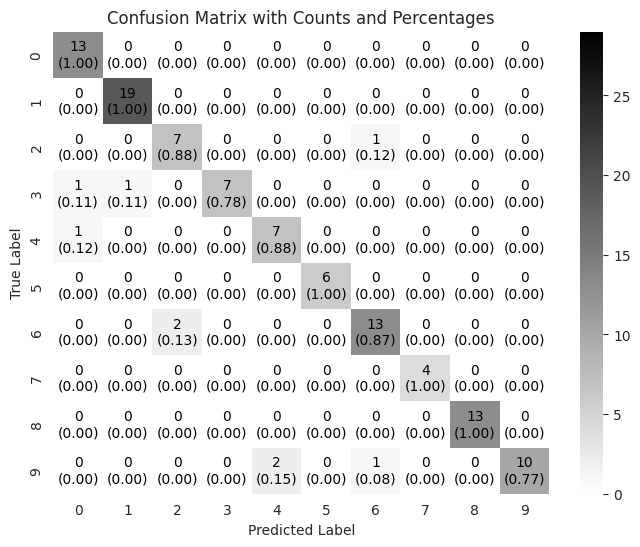

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
# pipline
pipeline = Pipeline([
    ('svm', SVC(probability=True))   # SVM step
])

# Define the parameter grid for grid search
param_grid = {
    'svm__C': [0.1, 1],     # SVM regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # SVM kernel: linear and RBF
    'svm__gamma': ['scale', 'auto']  # Kernel coefficient for RBF
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_minmax_scaled, y_encoded)

# Display the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Use the best estimator to predict on the test set
X_train, X_test, y_train, y_test = train_test_split(X_minmax_scaled, y_encoded, test_size=0.2, random_state=42)
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Test Set Accuracy:", accuracy)
print("Classification Report:\n", report)

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='binary', xticklabels=np.unique(y), yticklabels=np.unique(y), vmax=(np.max(cm)+10))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}\n({cm_percentage[i, j]:.2f})',
                 horizontalalignment='center', verticalalignment='center', color='black')
plt.title('Confusion Matrix with Counts and Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


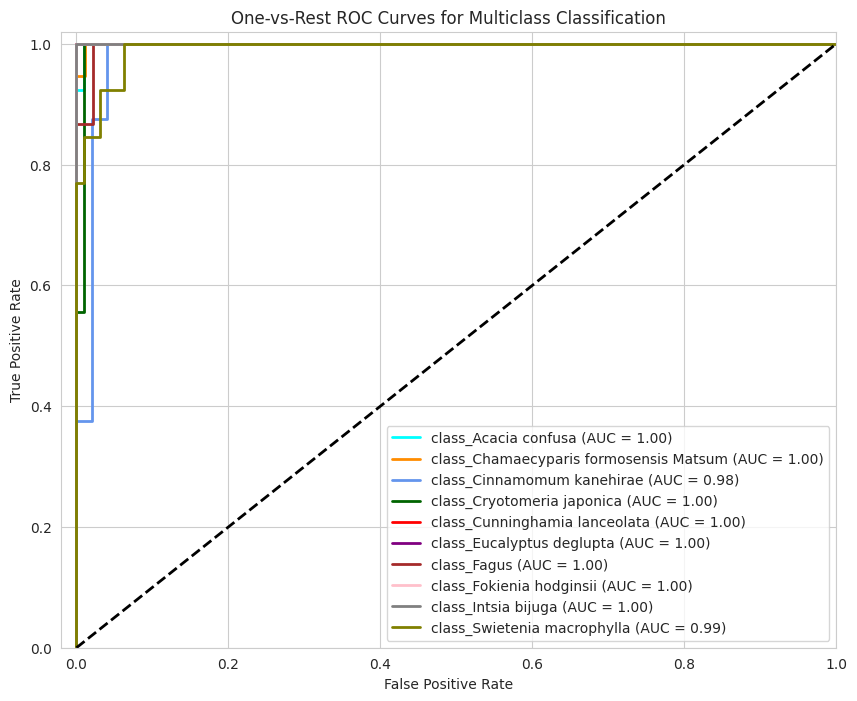

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming you have y_test and best_model from your previous code

# Binarize the output labels
n_classes = len(np.unique(y_encoded))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Get predicted probabilities
y_score = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    class_name = list(class_labels.keys())[list(class_labels.values()).index(i)]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'
                   ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [16]:
# show prediction's probability
best_model.predict_proba(X_test)

array([[0.01029935, 0.00370003, 0.00730609, ..., 0.01331378, 0.00246428,
        0.89193861],
       [0.00461474, 0.84637707, 0.0126587 , ..., 0.04203687, 0.00996211,
        0.01994505],
       [0.00523999, 0.00385655, 0.07223352, ..., 0.01448584, 0.00426896,
        0.0248063 ],
       ...,
       [0.00260833, 0.00180001, 0.00374529, ..., 0.00922453, 0.00291175,
        0.00744681],
       [0.01001255, 0.00287937, 0.01210101, ..., 0.0038323 , 0.00328875,
        0.00771525],
       [0.00564287, 0.01155898, 0.00100187, ..., 0.00223665, 0.00152023,
        0.94453871]])

In [17]:
# show prediction's label
best_model.predict(X_test)

array([9, 1, 6, 1, 8, 1, 8, 9, 1, 3, 0, 4, 7, 1, 4, 9, 8, 1, 2, 1, 4, 3,
       2, 6, 3, 0, 6, 6, 0, 6, 2, 3, 8, 5, 9, 8, 5, 1, 6, 4, 2, 6, 9, 8,
       5, 1, 2, 4, 7, 0, 4, 9, 8, 0, 9, 3, 1, 3, 2, 2, 3, 5, 1, 9, 1, 8,
       8, 6, 6, 4, 1, 4, 8, 9, 1, 9, 1, 8, 8, 1, 6, 0, 1, 1, 0, 0, 7, 0,
       6, 6, 8, 3, 2, 6, 0, 3, 7, 0, 5, 0, 9, 9, 0, 1, 6, 6, 5, 9])

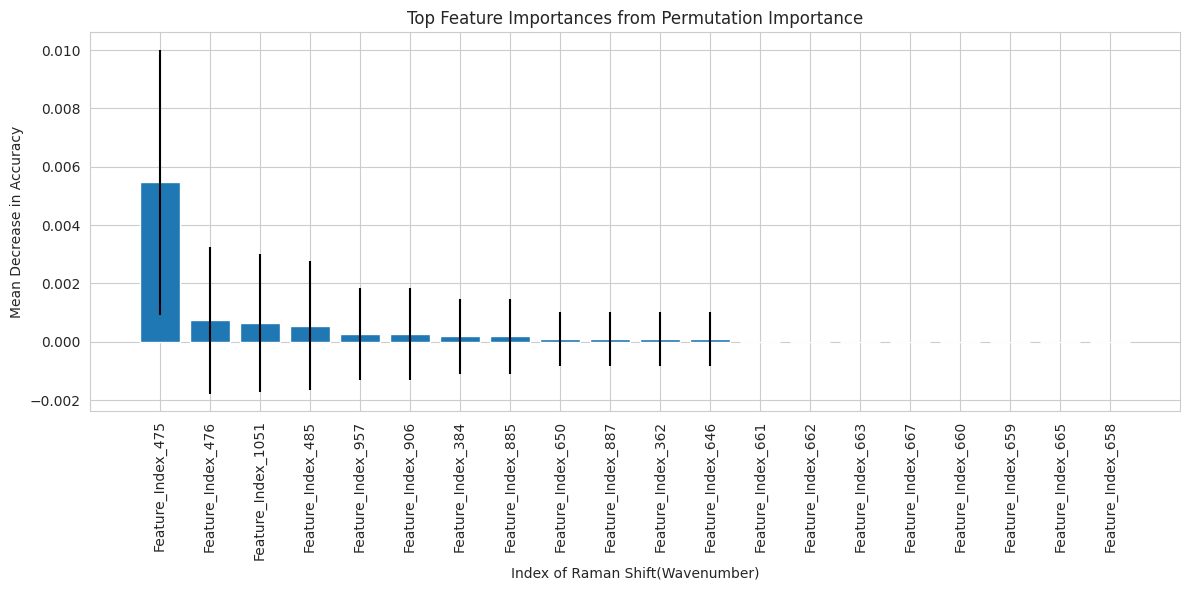

In [25]:
from sklearn.inspection import permutation_importance

# Compute permutation importances
result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=100,
    random_state=42,
    n_jobs=-1
)

# Extract importances
importances = result.importances_mean
std = result.importances_std

feature_names = [f'Feature_Index_{i}' for i in range(X_test.shape[1])]

# Identify top features
indices = np.argsort(importances)[::-1]
N = 20  # Number of top features to display
top_indices = indices[:N]

# Plot top feature importances
plt.figure(figsize=(12, 6))
plt.title('Top Feature Importances from Permutation Importance')
plt.bar(range(N), importances[top_indices], yerr=std[top_indices], align='center')
plt.xticks(range(N), [feature_names[i] for i in top_indices], rotation=90)
plt.xlabel('Index of Raman Shift(Wavenumber)')
plt.ylabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.show()


In [26]:
# select index of top 3 feature
top_indices[:12]

array([ 475,  476, 1051,  485,  957,  906,  384,  885,  650,  887,  362,
        646])

In [27]:
len(y_test)

108

In [28]:
# show feature's value of top 3 feature
def extract_feature_name(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None)
    df = df[0].str.split(";", expand=True)
    df = df.drop(columns=[2])
    df = df.astype(float)
    df = df.rename(columns={0: 'wave_number', 1: 'intensity'})
    return df

def load_feature_names(directory):
    feature_names = []
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                df = extract_feature_name(file_path)
                feature_names.append(df['wave_number'].values)
    return feature_names

feature_values = load_feature_names('dataset')
feature_values = np.array(feature_values)
# check the unique series of feature values
features_wavenumber = np.unique(feature_values, axis=0)
# show the top 3 feature values
features_wavenumber[:, top_indices[:12]]

array([[1204.212 , 1206.309 , 2267.99  , 1225.113 , 2112.643 , 2025.546 ,
        1009.695 , 1989.096 , 1556.865 , 1992.583 ,  961.4771, 1549.108 ],
       [1206.613 , 1208.71  , 2270.392 , 1227.515 , 2115.044 , 2027.947 ,
        1012.096 , 1991.498 , 1559.266 , 1994.984 ,  963.8782, 1551.509 ]])